In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import shortest_path
import math
import descartes
from shapely.geometry import Point,Polygon

You need Middle_Layer_Super_Output_Areas_December_2011_Boundaries_EW_BGC and Local_Authority_Districts_December_2019_Boundaries_UK_BFC as well as SAPE21DT4-mid-2018-msoa-syoa-estimates-unformatted.xlsx and ukmidyearestimates20182019ladcodes.xls and finally wu02ew_msoa and a version CurrentState that you produce in MakingCurrentStateOutOfInferenceData.ipynb for which you need to run the extremely long inference code on the English death data with literature parameters (or equivalent).
The data needed to run this notebook can be found [here](https://universityofcambridgecloud-my.sharepoint.com/:u:/g/personal/pbr28_cam_ac_uk/Ec-3aa6AR_xNvPbr7WqL7UsBhTxG-4TsVfzrrG7i_32GIw?e=l8ooyM). (Download the full zip archive, otherwise OneDrive complains.)

In [2]:

# Available options for generating the commuterverse network are listed here:

# Without cutting out small commute directions, the commuter network is very dense.
# We allow two types of cutoffs (that can be deactivated by setting them to 0):
# Ignore connection if fewer than this many people commute between two nodes (all ages)
all_age_cutoff = 10
# Ignore connection if fewer than this many people of a certain age group commute between two nodes
individual_age_cutoff = 3

# When the cutoffs are > 0, the number of nodes in the commuterverse gets reduced, which also
# reduces the overall number of people that commute to work. If this value is set to true,
# the the remaining nodes in the commuterverse get rescaled such that the overall number of
# people commuting remains the same.
rescale_work_population = True 

# Edit this function to add infected (or recovered) people to the network
def add_infected(table):
    # Example:
    #     table.loc[0, '16-24'] -= 5  # Susceptible 
    #     table.loc[0, '16-24_I'] += 5  # Infected
    #     table.loc[0, '16-24_R'] += 0  # Recovered
    # Adds 5 infected people in the City of London. First index is node id, second index is age group.
    pass  # No infected added


# Define average commute speed. The commute time is then computed using the distance between different MSOAs.
avg_commuting_speed = 20.0  # in km/h

# TODO: add choices for computing the commuting window here. At the moment, the logic for this is in the function
#       that saves the files, at the end of this notebook.

# TODO2: At the moment, people that work in the same node as they live are not added to the commuterverse. I am happy
#        to implement this when needed, however, we would need to decide on a value for the commute time then.

First we make the map of Britain, load scottish LADS and EW MSOAs and combine them. Check ONS coding if you do not understand

In [3]:
ScotLads={'Na h-Eileanan Siar',"Clackmannanshire",'Dumfries and Galloway',"East Ayrshire","East Lothian","East Renfrewshire","Eilean Siar","Falkirk", "Fife","Highland","Inverclyde", "Midlothian","Moray","North Ayrshire","Orkney Islands","Perth and Kinross","Scottish Borders",	"Shetland Islands",	"South Ayrshire", "South Lanarkshire", "Stirling", "Aberdeen City",	"Aberdeenshire", "Argyll and Bute",	"City of Edinburgh", "Renfrewshire", "West Dunbartonshire",	"West Lothian","Angus",	"Dundee City",	"North Lanarkshire",	"East Dunbartonshire",	"Glasgow City"}
Lads=gpd.read_file("shape/Local_Authority_Districts_December_2019_Boundaries_UK_BFC.shp")
SLads=Lads[Lads.lad19nm.isin(ScotLads)]
SLads=SLads.drop(columns=['objectid',"lad19nm",'lad19nmw','bng_e','bng_n','long','lat','st_lengths'])
SLads=SLads.rename(columns={'lad19cd':'AreaCode'})
SLads=SLads.to_crs(epsg=3395)
# SLads

DriverError: shape/Local_Authority_Districts_December_2019_Boundaries_UK_BFC.shp: No such file or directory

In [4]:
geometry_msoa = gpd.read_file("shape/Middle_Layer_Super_Output_Areas_December_2011_Boundaries_EW_BGC.shp")
geometry_msoa=geometry_msoa.drop(columns=['objectid',"msoa11nm",'msoa11nmw','st_lengths'])
geometry_msoa=geometry_msoa.rename(columns={'msoa11cd':'AreaCode'})
geometry_msoa=geometry_msoa.to_crs(epsg=3395)
geometry_msoa.head()

AreaCode    st_areasha                                           geometry
0  E02000001  2.905399e+06  MULTIPOLYGON (((-10774.144 6680905.516, -10739...
1  E02000002  2.165634e+06  POLYGON ((16484.756 6694037.987, 16482.035 669...
2  E02000003  2.143565e+06  POLYGON ((16767.621 6691585.838, 16517.775 669...
3  E02000004  2.490215e+06  POLYGON ((20603.001 6688323.301, 20482.619 668...
4  E02000005  1.186180e+06  POLYGON ((16684.345 6688907.596, 16781.998 668...

As a check we plot all of the places we have loaded and get a represntative point of each location to estimate travel times

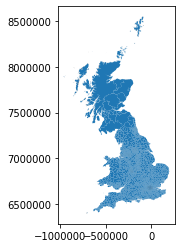

In [5]:
GB = gpd.GeoDataFrame(pd.concat([geometry_msoa,SLads], ignore_index=True), crs=geometry_msoa.crs)
GB["Center"]=GB.representative_point() 
GB.plot()

In [6]:
Lads=Lads.rename(columns={"lad19cd":'AreaCode'})

Next we load the current state of the infection which we got from Inference in the files for the individual E.csv,A.csv etc that we manipulate into CurrentState0-15.csv etc in MakingCurrentStates

In [7]:
InfecctionGroups=["S",'E','A','Ia','Is','Ih','Ic', "Im"]
CurrentState15=pd.read_csv('CurrentStateAge/CurrentState0-15.csv')
CurrentState15=CurrentState15.drop(columns=['Unnamed: 0'])
CurrentState15=CurrentState15.rename(columns={'Name':'ladcd',"S":"S15","E":"E15", "A":"A15", "Ia":"Ia15", "Is":"Is15","R":"R15","Im":"Im15"})


In [8]:
resident_data_20182_raw = pd.read_excel('data/ukmidyearestimates20182019ladcodes.xls', 'MYE2-All', skiprows=4)
resident_data_20182_raw=resident_data_20182_raw.drop(columns=['Geography1',"Name"])
resident_data_20182_raw=resident_data_20182_raw.rename(columns={90:'90+'})
resident_data_20182_raw=resident_data_20182_raw.rename(columns={'Code':'AreaCode','All ages':'All Ages'})
resident_data_20182_raw =resident_data_20182_raw[resident_data_20182_raw['AreaCode'].isin(CurrentState15.ladcd)]

In [9]:
CurrentState24=pd.read_csv('CurrentStateAge/CurrentState16-24.csv')
CurrentState24=CurrentState24.drop(columns=['Unnamed: 0'])
CurrentState24=CurrentState24.rename(columns={'Name':'ladcd',"S":"S24","E":"E24", "A":"A24", "Ia":"Ia24", "Is":"Is24","R":"R24","Im":"Im24"})

In [10]:
CurrentState34=pd.read_csv('CurrentStateAge/CurrentState25-34.csv')
CurrentState34=CurrentState34.drop(columns=['Unnamed: 0'])
CurrentState34=CurrentState34.rename(columns={'Name':'ladcd',"S":"S34","E":"E34", "A":"A34", "Ia":"Ia34", "Is":"Is34","R":"R34","Im":"Im34"})


In [11]:
CurrentState49=pd.read_csv('CurrentStateAge/CurrentState35-49.csv')
CurrentState49=CurrentState49.drop(columns=['Unnamed: 0'])
CurrentState49=CurrentState49.rename(columns={'Name':'ladcd',"S":"S49","E":"E49", "A":"A49", "Ia":"Ia49", "Is":"Is49","R":"R49","Im":"Im49"})


In [12]:
CurrentState64=pd.read_csv('CurrentStateAge/CurrentState50-64.csv')
CurrentState64=CurrentState64.drop(columns=['Unnamed: 0'])
CurrentState64=CurrentState64.rename(columns={'Name':'ladcd',"S":"S64","E":"E64", "A":"A64", "Ia":"Ia64", "Is":"Is64","R":"R64","Im":"Im64"})


In [13]:
CurrentState74=pd.read_csv('CurrentStateAge/CurrentState65-74.csv')
CurrentState74=CurrentState74.drop(columns=['Unnamed: 0'])
CurrentState74=CurrentState74.rename(columns={'Name':'ladcd',"S":"S74","E":"E74", "A":"A74", "Ia":"Ia74", "Is":"Is74","R":"R74","Im":"Im74"})


In [14]:
CurrentStateOldest=pd.read_csv('CurrentStateAge/CurrentState75+.csv')
CurrentStateOldest=CurrentStateOldest.drop(columns=['Unnamed: 0'])
CurrentStateOldest=CurrentStateOldest.rename(columns={'Name':'ladcd',"S":"S75+","E":"E75+", "A":"A75+", "Ia":"Ia75+", "Is":"Is75+","R":"R75+","Im":"Im75+"})


Next we will find the link between the LADs in which the current state is and the MSOAs which is what we will simulating in England and Wales.

In [15]:
Lads=Lads.rename(columns={'lad19cd':'AreaCode'})
msoa_to_lad = pd.read_csv('data/PCD_OA_LSOA_MSOA_LAD_FEB20_UK_LU.csv', encoding="latin_1", low_memory=False)
msoa_to_lad=msoa_to_lad.drop(columns=['pcd7','pcd8','pcds','dointr','doterm','usertype','oa11cd','lsoa11cd','lsoa11nm','msoa11nm','ladnm','ladnmw'])
msoa_to_lad=msoa_to_lad.rename(columns={'ladcd':'AreaCode'})
listUno=msoa_to_lad[msoa_to_lad['AreaCode'].isin(GB.AreaCode)]
listUno=listUno.drop_duplicates(subset=['AreaCode'], keep='first')
listUno=listUno.drop(columns=['msoa11cd'])
listUno['ladcd']=listUno['AreaCode']
listDuo=msoa_to_lad[msoa_to_lad['AreaCode'].isin(GB.AreaCode)==False]
listDuo=listDuo.rename(columns={'AreaCode':'ladcd','msoa11cd':'AreaCode'})
listDuo=listDuo.drop_duplicates(subset=['AreaCode'], keep='first')
msoa_to_lad=pd.concat([listUno, listDuo], ignore_index=True)

In [16]:
resident_data_20182_raw = pd.read_excel('data/ukmidyearestimates20182019ladcodes.xls', 'MYE2-All', skiprows=4)
resident_data_20182_raw=resident_data_20182_raw.drop(columns=['Geography1',"Name"])
resident_data_20182_raw_mid=resident_data_20182_raw.rename(columns={'Code':'ladcd'})
CurrentState2=CurrentState15.merge(resident_data_20182_raw_mid, on='ladcd')
CurrentState2=CurrentState2.rename(columns={'ladcd':'AreaCode'})
CurrentState2=CurrentState2.merge(Lads, on='AreaCode')
CurrentState15['DensityLAD']=CurrentState2['All ages']/CurrentState2['st_areasha']*1000*1000

In [17]:
msoa_to_ladInfec=msoa_to_lad.merge(CurrentState15, on='ladcd')
msoa_to_ladInfec=msoa_to_ladInfec.merge(CurrentState24, on='ladcd')
msoa_to_ladInfec=msoa_to_ladInfec.merge(CurrentState34, on='ladcd')
msoa_to_ladInfec=msoa_to_ladInfec.merge(CurrentState49, on='ladcd')
msoa_to_ladInfec=msoa_to_ladInfec.merge(CurrentState64, on='ladcd')
msoa_to_ladInfec=msoa_to_ladInfec.merge(CurrentState74, on='ladcd')
msoa_to_ladInfec=msoa_to_ladInfec.merge(CurrentStateOldest, on='ladcd')


Now we load the resident data from ONS and put it into the usual commuting age groups

In [73]:
resident_data_20181_raw = pd.read_excel('data/SAPE21DT4-mid-2018-msoa-syoa-estimates-unformatted.xlsx', 'Mid-2018 Persons', skiprows=4)
resident_data_20181_raw=resident_data_20181_raw.rename(columns={'Area Codes':'AreaCode'})
resident_data_20181_raw =resident_data_20181_raw[resident_data_20181_raw['AreaCode'].isin(GB.AreaCode)]
resident_data_20181_raw=resident_data_20181_raw.drop(columns=["Area Names"])
resident_data_20181_raw=resident_data_20181_raw.rename(columns={'90+':90})
resident_data_20182_raw = pd.read_excel('data/ukmidyearestimates20182019ladcodes.xls', 'MYE2-All', skiprows=4)
# resident_data_20182_raw=resident_data_20182_raw.drop(columns=['Geography1',"Name"])
resident_data_20182_raw=resident_data_20182_raw.rename(columns={'90+':90})
resident_data_20182_raw=resident_data_20182_raw.rename(columns={'Code':'AreaCode','All ages':'All Ages'})
resident_data_20182_raw =resident_data_20182_raw[resident_data_20182_raw['AreaCode'].isin(GB.AreaCode)]
resident_data_2018_raw=pd.concat([resident_data_20181_raw,resident_data_20182_raw],ignore_index=True)


In [74]:
# # We need to age-group the data to match the census workplace data
resident_data_2018 = resident_data_2018_raw[['AreaCode', 'All Ages']]
# resident_data_2018 = resident_data_2018.rename(columns={'Area Codes':'msoa', 'Area Names':'Name'})
age_groups = [5, 12, 16, 25, 35, 50, 65, 75]
i = 0
for i_end in age_groups:
    label = '{}-'.format(i)
    age_sum = resident_data_2018_raw[i].copy()
    i += 1
    while i < i_end:
        age_sum += resident_data_2018_raw[i]
        i += 1

    label = label + '{}'.format(i-1)
    resident_data_2018[label] = age_sum

age_sum = resident_data_2018_raw[i].copy()
i += 1
while i < 90:
    age_sum += resident_data_2018_raw[i]
    i += 1
age_sum += resident_data_2018_raw[90]
resident_data_2018['75+'] = age_sum


/home/jakub/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/home/jakub/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [51]:
ScotLads={'Na h-Eileanan Siar',"Clackmannanshire",'Dumfries and Galloway',"East Ayrshire","East Lothian","East Renfrewshire","Eilean Siar","Falkirk", "Fife","Highland","Inverclyde", "Midlothian","Moray","North Ayrshire","Orkney Islands","Perth and Kinross","Scottish Borders",	"Shetland Islands",	"South Ayrshire", "South Lanarkshire", "Stirling", "Aberdeen City",	"Aberdeenshire", "Argyll and Bute",	"City of Edinburgh", "Renfrewshire", "West Dunbartonshire",	"West Lothian","Angus",	"Dundee City",	"North Lanarkshire",	"East Dunbartonshire",	"Glasgow City"}

# The data of all residents in MSOAs from the 2011 census.
#From here https://www.nomisweb.co.uk/census/2011/qs103uk and download for MSOA and rename
resident_data_20112_raw = pd.read_excel('data/Mid-2011-unformatted-syoa-data-fileEdit.xls', 'Mid-2011 Persons')
resident_data_20112_raw=resident_data_20112_raw.rename(columns={'90+':90,' ALL AGES':'All Ages'})
resident_data_20112_raw=resident_data_20112_raw.rename(columns={'Code':'AreaCode','All ages':'All Ages'})
resident_data_20112_raw =resident_data_20112_raw[resident_data_20112_raw['Name'].isin(ScotLads)]
resident_data_20112_raw=resident_data_20112_raw.reset_index(drop=True)
resident_data_20182_raw=resident_data_20182_raw.reset_index(drop=True)
for i in range(0,len(resident_data_20112_raw)):
    if(resident_data_20112_raw['AreaCode'][i]=='S12000015'):
        resident_data_20112_raw['AreaCode'][i]='S12000047'
    if(resident_data_20112_raw['AreaCode'][i]=='S12000024'):
        resident_data_20112_raw['AreaCode'][i]='S12000048'
    if(resident_data_20112_raw['AreaCode'][i]=='S12000044'):
        resident_data_20112_raw['AreaCode'][i]='S12000050'
    if(resident_data_20112_raw['AreaCode'][i]=='S12000046'):
        resident_data_20112_raw['AreaCode'][i]='S12000049'
    if(resident_data_20112_raw['AreaCode'][i]=='S12000046'):
        resident_data_20112_raw['AreaCode'][i]='S12000049'
# # We need to age-group the data to match the census workplace data
resident_data_20112 = resident_data_20112_raw[['AreaCode', 'All Ages']]
# resident_data_2018 = resident_data_2018.rename(columns={'Area Codes':'msoa', 'Area Names':'Name'})
age_groups = [5,12,16, 25, 35, 50, 65, 75]
i = 0
for i_end in age_groups:
    label = '{}-'.format(i)
    age_sum = resident_data_20112_raw[i].copy()
    i += 1
    while i < i_end:
        age_sum += resident_data_20112_raw[i]
        i += 1

    label = label + '{}'.format(i-1)
    resident_data_20112[label] = age_sum

age_sum = resident_data_20112_raw[i].copy()
i += 1
while i < 90:
    age_sum += resident_data_20112_raw[i]
    i += 1
age_sum += resident_data_20112_raw[90]
resident_data_20112['75+'] = age_sum

resident_data_20111_raw = pd.read_csv('data/QS103UK_msoa.csv')
resident_data_20111_raw = resident_data_20111_raw.rename(columns={'geography code':'AreaCode', 'Age: All categories: Age; measures: Value':'All Ages'})
resident_data_2011Eng = resident_data_20111_raw[['AreaCode', 'All Ages']]

# We again need to group the data according to the workplace age structure.
age_groups = [5,12, 16, 25, 35, 50, 65, 75]
i = 0
age_sum = 0
for i_end in age_groups:
    label = '{}-'.format(i)
    if i == 0:
        age_sum = resident_data_20111_raw['Age: Age under 1; measures: Value'].copy()
    else:
        age_sum = resident_data_20111_raw['Age: Age {}; measures: Value'.format(i)].copy()
    i += 1
    while i < i_end:
        age_sum += resident_data_20111_raw['Age: Age {}; measures: Value'.format(i)]
        i += 1

    label = label + '{}'.format(i-1)
    resident_data_2011Eng[label] = age_sum

age_sum = resident_data_20111_raw['Age: Age {}; measures: Value'.format(i)].copy()
i += 1
while i < 100:
    age_sum += resident_data_20111_raw['Age: Age {}; measures: Value'.format(i)]
    i += 1
age_sum += resident_data_20111_raw['Age: Age 100 and over; measures: Value']
resident_data_2011Eng['75+'] = age_sum

resident_data_2011=pd.concat([resident_data_2011Eng,resident_data_20112],ignore_index=True)


/home/jakub/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/jakub/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/jakub/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/jakub/anaconda3/lib/python3.7/site-packages/ipykernel_l

We load the commuting groups and set a cutoff of 10 to not simulate too few people

In [54]:
cutoff=10
seriesEW=geometry_msoa['AreaCode']
#Load Scottish commute data
ScotCom=pd.read_csv("ScottishCommute.csv")
age_commute_table = pd.read_csv("data/wu02ew_msoa.csv")
#Trim down to data that is in the map
age_commute_table=age_commute_table[age_commute_table['Area of residence'].isin(seriesEW)]
age_commute_table=age_commute_table[age_commute_table['Area of workplace'].isin(seriesEW)]
ScotCom=ScotCom.drop(columns=["index"])
age_commute_table=pd.concat([age_commute_table,ScotCom], ignore_index=True)
age_commute_tableTot=age_commute_table[age_commute_table['All categories: Age 16 and over']>cutoff].reset_index(drop=True)
age_commute_table=age_commute_table[age_commute_table['Area of residence']!=age_commute_table['Area of workplace']]
age_commute_table=age_commute_table[age_commute_table['All categories: Age 16 and over']>cutoff].reset_index(drop=True)



In [55]:
age_commute_tableSummed=age_commute_tableTot[age_commute_tableTot['Area of residence']==age_commute_tableTot['Area of workplace']]
age_commute_tableSummed=age_commute_tableSummed.reset_index(drop=True)
age_commute_tableSummed=age_commute_tableSummed.rename(columns={"Area of residence":"AreaCode"})
# If you chose to rescale this is where you rescale to 2018 population
work_age_groups = ['16-24', '25-34', '35-49', '50-64', '65-74', '75+']
if rescale_work_population:
    for i in range(0,len(age_commute_tableSummed)):
        j=resident_data_2011.loc[resident_data_2011['AreaCode'] == age_commute_tableSummed['AreaCode'][i]]
        k=resident_data_2018.loc[resident_data_2018['AreaCode']  == age_commute_tableSummed['AreaCode'][i]]
        for (l, age_group) in enumerate(work_age_groups[0:]):
            age_commute_tableSummed[age_group][i]=age_commute_tableSummed[age_group][i]*k[age_group].values/j[age_group].values
# age_commute_tableSummed=GB.merge(age_commute_tableSummed, on='AreaCode')
# age_commute_tableSummed=age_commute_tableSummed.merge(resident_data_2018, on='AreaCode')


/home/jakub/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


Next we compute the time that each commuting person takes to get to there destination and transform from ONS coding to the code of the algorithm, this might take a while

In [ ]:
speed=20000
series=GB['AreaCode']
work_age_groups = ['16-24', '25-34', '35-49', '50-64', '65-74', '75+']
Tdistance=np.zeros(len(age_commute_table))
for i in range(0,len(age_commute_table)):
    # If you chose to rescale this is where you rescale to 2018 population
    if rescale_work_population:
        j=resident_data_2011.loc[resident_data_2011['AreaCode'] == age_commute_table['Area of residence'][i]]
        k=resident_data_2018.loc[resident_data_2018['AreaCode']  == age_commute_table['Area of residence'][i]]
        for (l, age_group) in enumerate(work_age_groups):
            age_commute_table[age_group][i]=age_commute_table[age_group][i]*k[age_group].values/j[age_group].values
    j=series[series==age_commute_table['Area of residence'][i]].index[0]
    k=series[series==age_commute_table['Area of workplace'][i]].index[0]
    age_commute_table['Area of residence'][i]=j
    age_commute_table['Area of workplace'][i]=k
    x1=GB['Center'][j].x
    y1=GB['Center'][j].y
    x2=GB['Center'][k].x
    y2=GB['Center'][k].y
    distance=(x1-x2)*(x1-x2)+(y1-y2)*(y1-y2)
    Tdistance[i]=np.sqrt(distance)/speed
    if(Tdistance[i]>3):
        Tdistance[i]=3
age_commute_table['TemporalDistance']=Tdistance
age_commute_table.insert(2, '0-15', np.zeros(len(age_commute_table.index), dtype=int))


In [86]:
# 1. Write down the commute network:

# Get into the format neede for the algorithm: Rows of the form
#     Age group nr, residence index, residence index, work index, number of people commuting (scaled to 2019), 
#     commute start 1, commute start 2, commute end 1, commute end 2, allow S, allow I, allow R
# written in a CSV file.
# This may take a while!
filename = 'commuter_networks.csv'
allow_S = 1
allow_E = 1
allow_A = 1
allow_Ia1 = 1
allow_Ia2 = 1
allow_Ia3 = 1
allow_Is1 = 0
allow_Is2 = 0
allow_Is3 = 0
allow_R = 1
work_age_groups = ['0-15', '16-24', '25-34', '35-49', '50-64', '65-74', '75+']
with open(filename,  'w') as f:
    f.write("Home,From,To,Age,#to_move,%to_move,t1,t2,ct1,ct2,allow_S, allow_E, allow_A, allow_Ia1, allow_Ia2, allow_Ia3, allow_Is1,  allow_Is2,  allow_Is3, allow_R)\n")
    for j in age_commute_table.index:
        row = age_commute_table.loc[j]
        for (i, age_group) in enumerate(work_age_groups[1:]):
            count = row[age_group].astype(int)

            # Everyone is in office between 9:00 and 10:00 and leaves between 17:00 and 18:00:
            buffer = min(row.TemporalDistance, 1.0)
            
            morning_start_1 = 9 - row.TemporalDistance
            morning_start_2 = 9 - row.TemporalDistance + buffer
            morning_end_1 = 9
            morning_end_2 = 9 + buffer
            
            evening_start_1 = 17
            evening_start_2 = 17 + buffer
            evening_end_1 = 17 + row.TemporalDistance
            evening_end_2 = 17 + row.TemporalDistance + buffer

            if count > individual_age_cutoff:
                # home -> work
                f.write("{}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}  \n".format(
                        int(row['Area of residence']), int(row['Area of residence']),  int(row['Area of workplace']),  i+3,
                        count,-1, morning_start_1, morning_start_2, morning_end_1, morning_end_2,
                        allow_S, allow_E, allow_A, allow_Ia1, allow_Ia2, allow_Ia3, allow_Is1,  allow_Is2,  allow_Is3, allow_R)
                    )
                # work -> home
                f.write("{}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {} , {} \n".format(
                        int(row['Area of residence']), int(row['Area of workplace']),  int(row['Area of residence']),  i+3, 
                        -1, 1, evening_start_1, evening_start_2, evening_end_1, evening_end_2,
                        allow_S, allow_E, allow_A, allow_Ia1, allow_Ia2, allow_Ia3, allow_Is1,  allow_Is2,  allow_Is3, allow_R)
                    )

In [60]:
# 2. Write down the nodes and geographical location:

# We again use a representative point in each MSOA as its location. This point is guaranteed to
# be in the MSOA and is given in meters.
filename = 'node_positions.csv'
with open(filename,  'w') as f:
    f.write('Node,x,y\n')
    for i in GB.index:
        x = GB['Center'][i].x
        y = GB['Center'][i].y
        f.write('{}, {:1f}, {:1f}\n'.format(i, x, y))

In [78]:
# 3. Write down population and infected numbers

filename = 'node_populations.csv'
age_groups = ['0-4','5-11', '12-15', '16-24', '25-34', '35-49', '50-64', '65-74', '75+']
ages = ['15','15', '15', '24', '34', '49', '64', '74', '75+']

midPanda=msoa_to_ladInfec.merge(resident_data_2018, on='AreaCode')
node_population_table = GB.merge(midPanda, on='AreaCode')
# node_population_table['DensityMsoa']=node_population_table['All Ages']/node_population_table['st_areasha']*1000*1000
# x=node_population_table['DensityLAD'].values
# y=node_population_table['DensityMsoa'].values

# #the density dependence of infection, set the ratio to 1 if detail is not necessary
# p=[0.00400384, 0.28323853]
# def func(x):
#     a=p[0]*np.power(x,p[1])
#     return a
# VectorFunc=np.vectorize(func)
# ratio=VectorFunc(x)/VectorFunc(y)
# node_population_table['ratio']=ratio



# We get the individual infected/Susceptible/other people here
for (age_group, age) in zip(age_groups, ages):
    S=node_population_table['S'+age]*node_population_table[age_group]
    node_population_table[age_group+'_S'] = S.astype(int)
    E =node_population_table['E'+age]*node_population_table[age_group]
    node_population_table[age_group+'_E']=E.astype(int)
    A=node_population_table['A'+age]*node_population_table[age_group]
    node_population_table[age_group+'_A'] =A.astype(int)
    Ia1=node_population_table['Ia'+age]*node_population_table[age_group]/3*2
    node_population_table[age_group+'_Ia1']=Ia1.astype(int)
    Ia2=node_population_table['Ia'+age]*node_population_table[age_group]/9
    node_population_table[age_group+'_Ia2']=Ia2.astype(int)
    Ia3=node_population_table['Ia'+age]*node_population_table[age_group]/9
    node_population_table[age_group+'_Ia3']=Ia3.astype(int)
    Is1=node_population_table['Is'+age]*node_population_table[age_group]/3*2
    node_population_table[age_group+'_Is1'] =Is1.astype(int)
    R=node_population_table['R'+age]*node_population_table[age_group]
    Is2=node_population_table['Is'+age]*node_population_table[age_group]/6
    node_population_table[age_group+'_Is2'] =Is2.astype(int)
    Is3=node_population_table['Is'+age]*node_population_table[age_group]/9
    node_population_table[age_group+'_Is3'] =Is3.astype(int)
    node_population_table[age_group+'_R'] =R.astype(int)
# Change population table here to add infected or recovered persons:
# add_infected(node_population_table)

# Write to file:
with open(filename, 'w') as f:
    f.write('Home, Location, Area, S0, E0, A0, Ia01, Ia02, Ia03, Is01, Is02, Is03, R0, S1, E1, A1, Ia11, Ia12, Ia13, Is11, Is12, Is13, R1, S2, E2, A2, Ia21, Ia22, Ia23, Is21, Is22, Is23, R2\n')
    
    for i in node_population_table.index:
            row = node_population_table.loc[i, :]
            line = '{}, {}, {}'.format(i, i, row['st_areasha'])
            for (j, age_group) in enumerate(age_groups):
                line += ', {}, {}, {}, {}, {}, {}, {}, {}, {} , {}'.format(row[age_group+'_S'] , row[age_group+'_E'], row[age_group+'_A'], row[age_group+'_Ia1'], row[age_group+'_Ia2'], row[age_group+'_Ia3'], row[age_group + '_Is1'], row[age_group + '_Is2'], row[age_group + '_Is3'], row[age_group + '_R'])
            line += '\n'
            f.write(line)
#     for l in range(len(node_population_table), len(Combined)):
#             line = '{}, {}, {}'.format(l, l, 0.01)
#             for (j, age_group) in enumerate(work_age_groups):
#                 line += ', {}, {}, {}, {}, {}, {}, {}, {}, {}, {}'.format(0 , 0, 0, 0, 0, 0, 0, 0, 0, 0)
#             line += '\n'
#             f.write(line)

In [85]:
# 4. Write down the percentage of people working:

# Get into the format neede dfor the algorithm: Rows of the form
#     Age group nr, residence index, number of people working (scaled to 2019), number of people
# written in a CSV file.
# This may take a while!
filename = 'work percentage.csv'
popTable = GB.merge(resident_data_2018, on='AreaCode')
age_groups = ['0-4','5-11', '12-15', '16-24', '25-34', '35-49', '50-64', '65-74', '75+']
with open(filename,  'w') as f:
    f.write("loc,age,Nworking,N \n")
    for j in age_commute_tableSummed.index:
        row2 = popTable.loc[j]
        row = age_commute_tableSummed.loc[age_commute_tableSummed['AreaCode']  == popTable["AreaCode"][j]]
        for (i, age_group) in enumerate(age_groups[1:]):
            # Age group nr, residence index, number of people working (scaled to 2019), number of people
            if((age_group=='5-11') or (age_group=='12-15')):
                f.write("{}, {}, {}, {}  \n".format(
                        j, i+1,  int(row2[age_group]), int(row2[age_group])  )
                    )
            else:
                count = row[age_group].astype(int)
                f.write("{}, {}, {}, {}  \n".format(
                        j, i+1,  int(row[age_group]), int(row2[age_group])  )
                    )